In [1]:
# Para cargar lo necesario
import pickle
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../')

from src import customFunc as cf
from src import ansatzs as anz

c:\Users\juanl\miniconda3\envs\qiskit-tfm\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


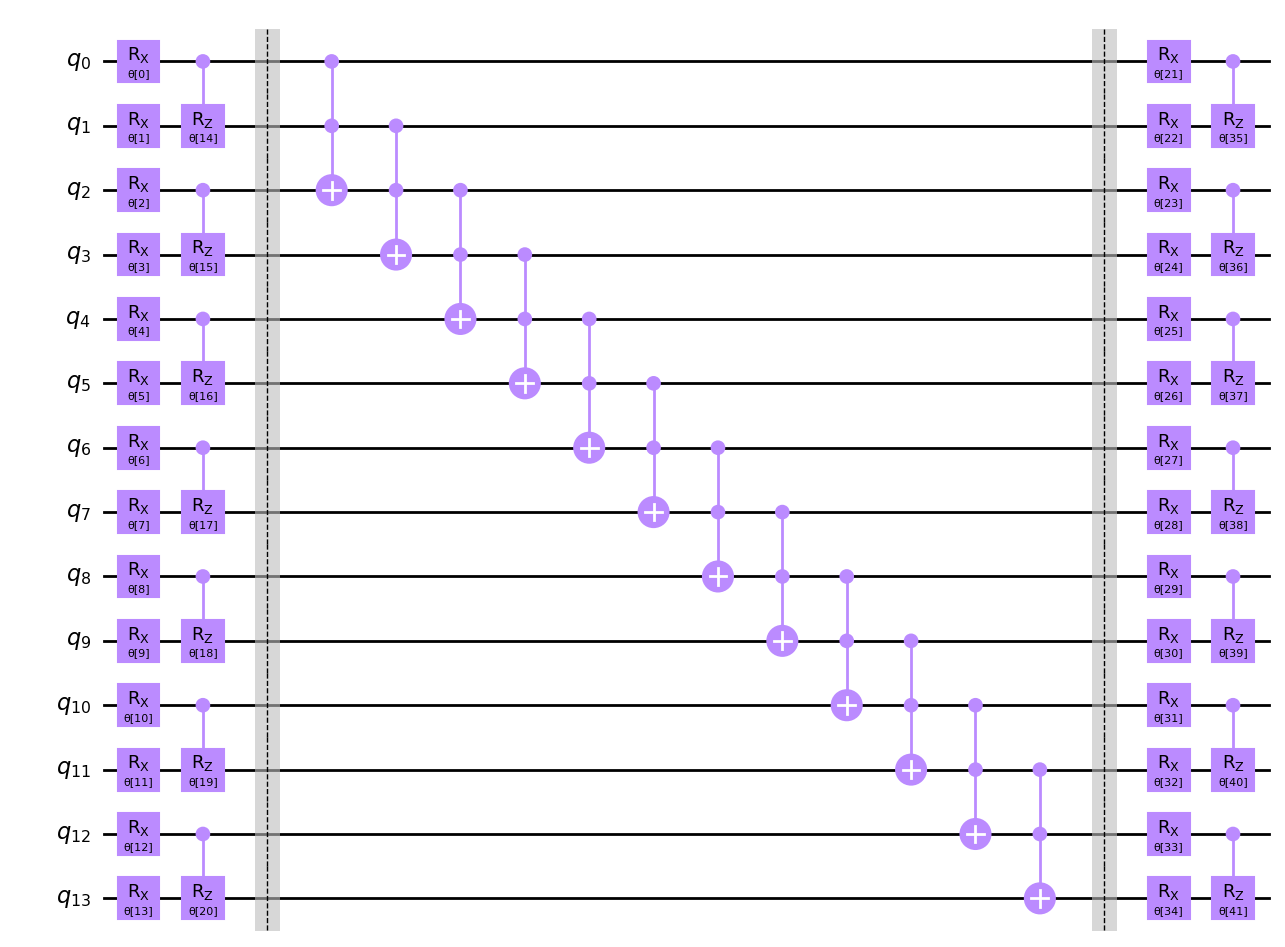

In [11]:
ansatz, n_params = anz.build_Nlocal_ansatz(14, 1)
ansatz.decompose().draw("mpl")

In [5]:
# Cargamos los hamiltonianos y las energías de repulsión y aplicamos el VQE

distances = np.linspace(0.25, 4, 25)
total_energies = []

for dist in distances:
    # Hamiltonianos
    with open(f"data/hamiltonian{dist:.3f}.pkl", "rb") as f:
        hamiltonian = pickle.load(f)
    # Energías de repulsión
    with open(f"data/nuclear_repulsion{dist:.3f}.pkl", "rb") as f:
        nuclear_repulsion = pickle.load(f)

    total_energies.append(cf.VQE_minimization_BP(anz.build_Nlocal_ansatz, 14, 14, hamiltonian, [], print_info=False, plot_info=False)["minimum_values"][0] + nuclear_repulsion)

plt.plot(distances, total_energies)

KeyboardInterrupt: 

### Analizamos BP alrededor del punto de equilibrio estable d = 1.1031

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.80499838+0.j,  0.17472226+0.j, -0.23347838+0.j,  0.12184887+0.j,
  0.17472226+0.j,  0.16970294+0.j, -0.23347838+0.j,  0.16685625+0.j,
  0.04500738+0.j,  0.04500738+0.j,  0.04500738+0.j,  0.04500738+0.j,
  0.16685625+0.j,  0.17539742+0.j,  0.12184887+0.j])

Calculando varianzas con 4 qubits.

Varianza del valor esperado: 0.03716057211789833
Varianza de la derivada: 0.015908318032484103

Calculando varianzas con 5 qubits.

Varianza del valor esperado: 0.02851996999134648
Varianza de la derivada: 0.007114603561990323

Calculando varianzas con 6 qubits.

Varianza del valor esperado: 0.02016024333223356
Varianza de la derivada: 0.003367757330146568

Calculando varianzas con 7 qubits.

Varianza del valor esperado: 0.01635812312700265
Varianza de la derivada: 0.0018441178938813608

Calculando varianzas con 8 qubits.

Varianza del valo

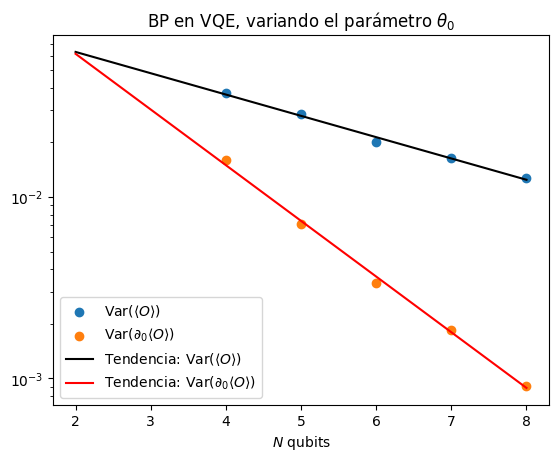


Calculando varianzas con 4 qubits.

Varianza del valor esperado: 0.03727457032327928
Varianza de la derivada: 0.022453885301148127

Calculando varianzas con 5 qubits.

Varianza del valor esperado: 0.027843800390883335
Varianza de la derivada: 0.01382068712001636

Calculando varianzas con 6 qubits.

Varianza del valor esperado: 0.018703012833234816
Varianza de la derivada: 0.004759762916258766

Calculando varianzas con 7 qubits.

Varianza del valor esperado: 0.01612489645875514
Varianza de la derivada: 0.003176677487260103

Calculando varianzas con 8 qubits.

Varianza del valor esperado: 0.014317531678780441
Varianza de la derivada: 0.0019159117881665747

Pendiente para valor esperado: -0.2459899003944646.
R^2 para valor esperado: 0.9499391904527429.

Pendiente para derivada: -0.6392870750974436.
R^2 para derivada: 0.9742639950859473.


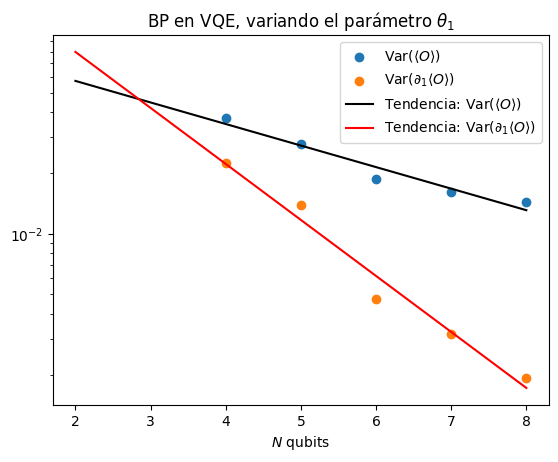


Calculando varianzas con 4 qubits.

Varianza del valor esperado: 0.03814061184178873
Varianza de la derivada: 0.014188217555567722

Calculando varianzas con 5 qubits.

Varianza del valor esperado: 0.029436828543720858
Varianza de la derivada: 0.012351486331120275

Calculando varianzas con 6 qubits.

Varianza del valor esperado: 0.01925422949710134
Varianza de la derivada: 0.0069103091239461475

Calculando varianzas con 7 qubits.

Varianza del valor esperado: 0.016373682787293776
Varianza de la derivada: 0.003446304812210962

Calculando varianzas con 8 qubits.

Varianza del valor esperado: 0.011386540872337281
Varianza de la derivada: 0.0016509456882950087

Pendiente para valor esperado: -0.30042664428688376.
R^2 para valor esperado: 0.9872111053799193.

Pendiente para derivada: -0.5578601023250505.
R^2 para derivada: 0.9570792101419137.


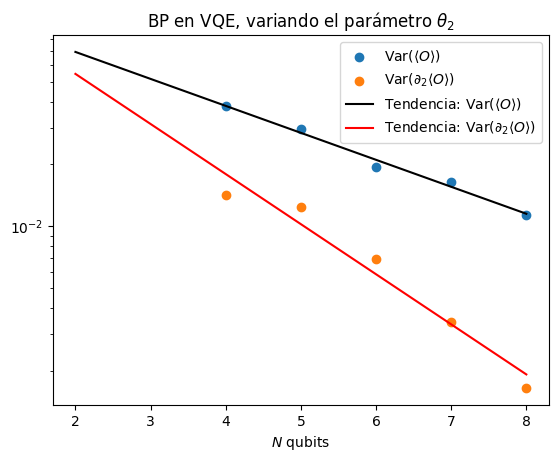

In [ ]:
# Analizamos BP alrededor del punto de equilibrio estable d = 1.1031

with open("data/hamiltonian1.031.pkl", "rb") as f:
    hamiltonian = pickle.load(f)

print(hamiltonian)

data = []

for j in range(3):
    data.append(cf.variance_vs_nQubits(anz.build_Nlocal_ansatz, 14, 20, hamiltonian, j, 1000, True, True, True))